In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.vector_timewarpers as vtw
import torch
import torch.nn as nn

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5qj4cezg because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/tsr42/anaconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
fulldat = np.load("../data/trainTest2DLetterACache.npz")
print(fulldat["train"].shape)
dat = fulldat["train"]
numdims = dat.shape[2]
numts = dat.shape[1]
numtrajs = dat.shape[0]

(3750, 200, 2)


# Introduction
A DMP is a combination of a simple attractor-to-goal model and a forcing term.

The forcing term is a function of phase `x` which (without external disturbances) is a direct function of time `t`.
DMP models from the original Ijspeert paper
(and the Learning Parametric Dynamic Movement... paper)
have the forcing term affect velocity, not acceleration.

The forcing term is a linear combination of kernel functions.
The linear combination values is computed using locally weighted regression on 
the difference between the velocities that would exist at phase `x`
if we just had the attractor-to-goal and no forcing term and no external velocities
and the trajectory's actual velocity at phase `x`.
Note that this does not find the minimum squared positional error optimal weights.
Both because it is fitting velocities, not positions,
and because it is using a local fitting procedure, not finding the optimal combination
to reduce error across the whole trajectory.

# Phase vs Time

We don't use any of the flexibility that this additional complication allows,
but for consistency with Ijspeert 2002,
instead of functions of `t` for kernel functions, we use kernel functions that are 
a function of `x` according to the equations below.
This additional complication is only useful if 1) you have external perturbations during motion
and 2) you add some type of delaying/forcing function to how the phase evolves over time.
$$ \tau \dot v = \alpha_v (\beta_v (g-x) - v) $$
$$ \tau \dot x = v $$
Since we don't use any of the additional flexibility that this equation allows, this is exactly the same as saying that
$$ x = a e^{-\phi_1 t} + b e^{-\phi_2 t} $$
Where the $\phi$s are $\frac 1 {2\tau} (-\alpha_v \pm \sqrt{\alpha_v^2 - 4 \alpha_v \beta_v})$
but since $\alpha_v$ and $\beta_v$ are chosen arbitrarily, we can instead just arbitrarily set 
$x = e^{-\phi t}$ with $\phi = \log(100)$, making  $x_0 = 1$ and $\dot x_0 = -\phi$


In [3]:
tau = 1
def phase_func(t):
    phasefactor = np.log(100)
    return np.exp(-t * phasefactor)
# ts is the (scaled) timestamp
ts = np.linspace(0,1,numts)
# xs is the associated ``phase''
xs = phase_func(ts)

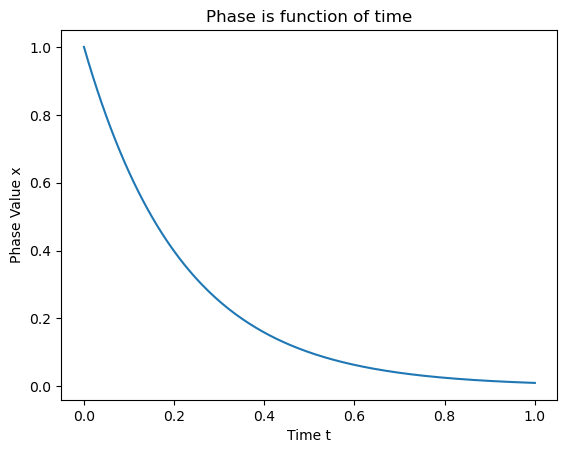

In [4]:
plt.plot(ts,xs)
plt.xlabel("Time t")
plt.ylabel("Phase Value x")
plt.title("Phase is function of time");

## Basis Functions
The forcing function is a linear combination of basis functions.
The `N` different basis functions are computed as Gaussians over the phase, with equally spaced centers
``cs`` and standard deviation `sigma` that scales with the center of the basis function.

In [5]:
N = 60
cs = phase_func(np.linspace(0,1,N,endpoint=True))
sigma = 2/N

# basisphis is N x numts
# Note that instead of using a constant `sigma`, we use `sigma * c`.
# This makes each basis function nicely translationally-symmetric with others
# as a funciton of time. (compare, eg, to Ijspeert 2002's Figure 1, which is grossly)
basisphis = np.array([np.exp(-(xs - c)**2/((sigma * c)**2)) for c in cs])

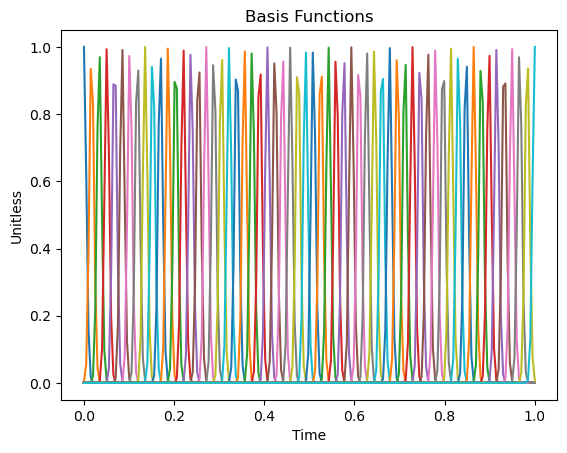

In [6]:
plt.plot(ts,basisphis.T)
plt.xlabel("Time")
plt.ylabel("Unitless")
plt.title("Basis Functions");

# Estimating forcing function from data

Ijspeert 2002 explains:
For learning from a given sample trajectory,
characterized by a trajectory y demo (t), $\dot y$ demo (t) and duration T , a supervised learning problem can be formulated with the target trajectory f target = τ $\dot y$ demo − z demo
for Eq.1 (right), where z demo is obtained by integrating Eq.1 (left) with y demo instead of y.

The equations (Eq. 1) of Ijspeert 2002 are:
$$ \tau \dot z = \alpha_z (\beta_z(g-y)-z) $$
$$ \tau \dot y = z + f $$

And the integration to solve for $z(t)$ is (using $s$ instead of $t$ for evaluation to avoid
using same symbol $t$ for $dt$ and for limit of integration):
$$ z(s) = \frac 1 \tau \int_0^s \alpha_z (\beta_z (g-y_{demo}) - z) dt $$

In this way, we're estimating the forcing function that "must have existed" during the training trajectory.

The $z(t)$ we're calculating is hard to think about, but it can be thought of as "the component of the velocity due to the goal attractor". And the total velocity of the trajectory is that value $z$ plus the forcing term $f$ (times the time scaling term $\tau$).

In [7]:
# we choose these according to the suggested values in Ijspeert 2013 (didn't see suggestions in Ijspeert 2002)
alpha_z = 25
beta_z = alpha_z/4

In [8]:
# Perform numeric integration on the training data to estimate
# the component of the velocity of the trajectory that is due to the "point-attractor"
# component of the trajectory model.
# The rest of the velocity of the trajectory will be due to the "forcing term" f
def numeric_integration(ydemos, ts, tau, g, alpha_z, beta_z):
    # We perform numeric integration using small rectangles
    # with width dt = step_size
    # and height equal the value of 1/tau \alpha_z (\beta_z (g-y_{demo}) - z)
    # evaluated at the left of the rectangle.
    step_size = 0.00001
    # start integrating at the first ts
    t = ts[0]
    # Since our y_demo is only known at certain places,
    # keep track of the index i
    # of the smallest ts that is larger than our current value of t
    # when we want to compute y_delta at some t between ts[i-1] and ts[i]
    # we do linear interpolation
    i = 1
    # keep track of our cumulative sum (which numerically estimates the integral)
    z = 0
    # keep track of the integral as it progresses.
    # append a 0 to start, to avoid the fencepost problem (otherwise we have one fewer zs than ts)
    zs = []
    zs.append(z)
    # compute the integral up to each of the t values in ts, appending the result to zs each time
    while i < len(ts):
        # keep on adding dt to t and summing the rectangle value until we hit the next value in ts
        while i < len(ts) and t < ts[i]:
            # we use linear interpolation to compute the ydemo value at the intermediate t value
            interp_frac = (t - ts[i-1])/(ts[i] - ts[i-1])
            y = (1-interp_frac) * ydemos[i-1] + interp_frac * ydemos[i]
            # compute the area of the rectangle and add it to our cumulative integration.
            # note that z appears on the left and right of this expression
            z = z + (alpha_z * (beta_z * (g - y) - z)/tau * step_size)
            t += step_size
        zs.append(z)
        i += 1
    return np.array(zs)

# Example Fitting Single Dim of Single Trajectory

dim 0
dim 1


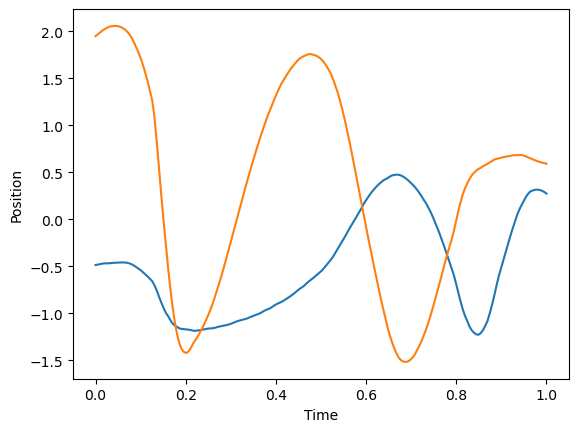

In [9]:
# zdemos is (what) the velocity of the trajectory (would be, if just the attractor model)
zdemos = []
# ftargets is the imputed forcing function
ftargets = []
# both those are arrays of arrays, with indices according to
# forcing velocity = ftargets[trajectory index][dimension]


for i in range(1):
    ftargets.append([])
    zdemos.append([])
    for dim in range(2):
        print("dim",dim)        
        ydemo = dat[i,:,dim]
        plt.plot(ts,ydemo)
        plt.xlabel("Time")
        plt.ylabel("Position")
        ydemoprime = (ydemo[2:]-ydemo[:-2])/(ts[1]-ts[0])/2
        ydemoprime = np.concatenate(((ydemo[1:2]-ydemo[:1])/(ts[1]-ts[0]),ydemoprime,(ydemo[-1:]-ydemo[-2:-1])/(ts[1]-ts[0])))

        yzero = ydemo[0]
        g = ydemo[-1]
        
        zdemo = numeric_integration(ydemo, ts, tau, g, alpha_z, beta_z)
        ftarget = tau * ydemoprime - zdemo
        ftargets[-1].append(ftarget)
        zdemos[-1].append(zdemo)

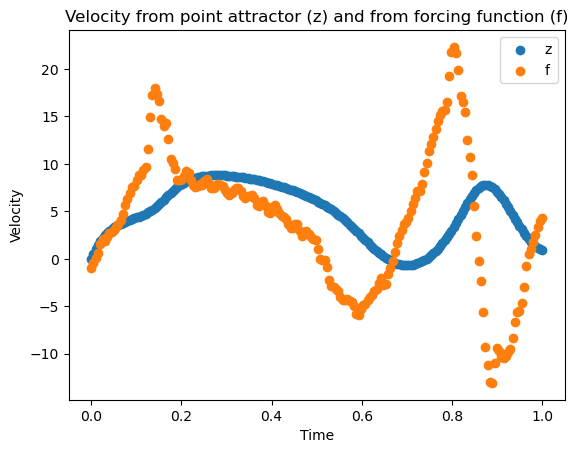

In [10]:

# indices are [trajectory_index][dimension]
plt.scatter(ts,zdemos[0][0],label="z")
plt.scatter(ts,-ftargets[0][0],label="f")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Velocity from point attractor (z) and from forcing function (f)")
plt.legend()
plt.show()

###  Fit the forcing function
Use locally-weighted regression to fit the forcing function.
Note that this is a very particular way of fitting $f$ using the basis functions.

In Ijspeert 2002, the locally weighted regression fits $f$ as a scalar coefficient $w$ times our canonical velocity $v$ (using a local weighting factor $\psi_i$).

However, since we have a very, very simple canonical model, we the canonical velocity $v = \tau \dot x$, which is proportional to the phase $x$. So it doesn't really matter whether we fit to $v$ or $x$. The coefficients will only differ by a constant factor.
Likewise, the scaling by `(g-yzero)` only affects the relative scaling of the coefficients between different trajectories. For a single trajectory that will just scale all the coefficients by a constant.
So, it seems fine to incorporate that from Ijspeert 2013 as well.

Thus, we fit `f(t)` as a multiple of `x(t)(g-yzero)` around the region where $\psi_i$ is active.

In [11]:
# For the weighting kernel $\psi_i$ corresponding to the `i`'th index of `basisphis`
# Model the `targetfunction` $f$ as a linear multiple of `xs*(g-yzero)`
# to minimize $\psi_i * (f - xs*(g-yzero))^2$
# Note that basisphis[i], targetfunction, xs are all vectors where each index
# corresponds to a different t in ts.
def fit_target_i(i, basisphis, targetfunction, xs, yzero, g):
    # scale the xs by the scaling factor associated with the training trajectory
    s = xs * (g - yzero)
    # create the diagonal matrix associated with the basis function
    gamma = np.diag(basisphis[i])
    # equation 2.14 from Dynamical Movement Primitives: Learning Attractor Models for Motor Behaviors
    numerator = s @ gamma @ targetfunction
    denominator = s @ gamma @ s
    return numerator / denominator

In [12]:
wss = []
fitted_fs = []

# for a training trajectory
for i in range(1):
    # compute, for each dimension:
    # the weights of each basis functions
    # and the resulting basis function.
    # wss is indexable as [trajectoryId][dimension][basisindex]
    # fitted_fs is indexable as [trajectoryId][dimension][ts]
    wss.append([])
    fitted_fs.append([])
    for dim in range(2):
        # take in one dimension of one trajectory
        ydemo = dat[i,:,dim]
        # get its start and end for scaling
        yzero = ydemo[0]
        g = ydemo[-1]
        # compute the weight for each basis function
        # that best matches the already-computed ftargets
        ws = np.array([fit_target_i(basisIndex, basisphis, ftargets[i][dim], xs, yzero, g) for basisIndex in range(len(basisphis))])
        # compute the reconstructed ftargets that those weights generate (scaling back up again using g-yzero)
        fitted_f = np.einsum("it,i->t",basisphis,ws)/np.einsum("it->t",basisphis) * xs * (g-yzero)
        # save the weights and the fitted model
        wss[-1].append(ws)
        fitted_fs[-1].append(fitted_f)

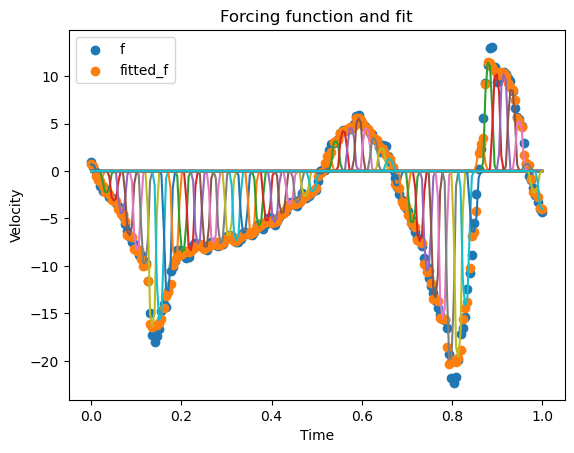

In [13]:
# indices are [trajectory_index][dimension]
plt.scatter(ts,ftargets[0][0],label="f")
plt.scatter(ts,fitted_fs[0][0],label="fitted_f",c="C1")
# get the trajectory dimension start and end for scaling
ydemo = dat[0,:,0]
yzero = ydemo[0]
g = ydemo[-1]
for basisIndex in range(len(wss[0][0])):
    plt.plot(ts,basisphis[basisIndex] * wss[0][0][basisIndex] * xs * (g-yzero)/np.einsum("it->t",basisphis))
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Forcing function and fit")
plt.legend()
plt.show()

## Reconstruct trajectory
From the weights we reconstructed the forcing function `fitted_f`.
We can then integrate and simulate forward to see what the point-attractor and forcing function together would cause the
trajectory to actually be.

In [14]:
def simulate(fitted_f, ts, g, alpha_z, beta_z, yzero):
    step_size = 0.00001
    i = 0
    t = ts[i]
    ys = [] # position
    zs = [] # velocity
    y = yzero
    z = 0
    t = 0
    while i < len(ts):
        while i < len(ts) and t < ts[i]:
            interp_frac = (t - ts[i-1])/(ts[i] - ts[i-1])
            f = (1-interp_frac) * fitted_f[i-1] + interp_frac * fitted_f[i]
            z += alpha_z * (beta_z * (g - y) - z)/tau * step_size
            y += (z + f)/tau * step_size
            t += step_size
        ys.append(y)
        zs.append(z)
        i += 1
    return (np.array(ys), np.array(zs))

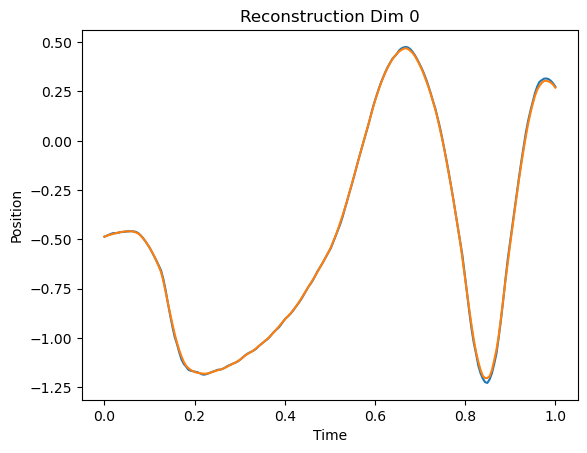

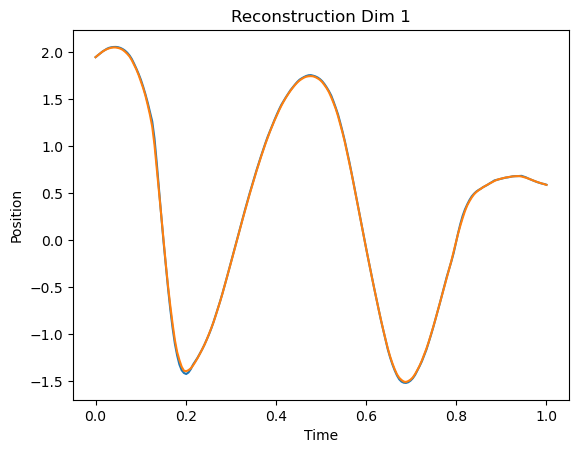

In [15]:
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    plt.plot(ts, ydemo,   label="actual")
    plt.plot(ts, recon_ys,label="recon")
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.title(f"Reconstruction Dim {dim}")
    plt.show()

## Single Function to Compute DTW parameterization of training trajectory
Write a single function to compute the DTW parameters computed in the steps above
(and confirm you get the same answer).

In [16]:
# traj should be 2d
def compute_dtw_parameterization(traj, basisphis, ts, xs, tau, alpha_z, beta_z):
    assert len(traj.shape) == 2, "traj should be 2d...just send in one trajectory"
    # reset the trajectory to start at (0,0)
    # and save the actual starting position to start_offset variables
    start_offset_0, start_offset_1 = traj[0]
    ydemos = traj-traj[0:1]
    result_dictionary = {}
    for dim in range(2):
        ydemo = ydemos[:,dim]
        ydemoprime = (ydemo[2:]-ydemo[:-2])/(ts[1]-ts[0])/2
        ydemoprime = np.concatenate(((ydemo[1:2]-ydemo[:1])/(ts[1]-ts[0]),ydemoprime,(ydemo[-1:]-ydemo[-2:-1])/(ts[1]-ts[0])))
        yzero = ydemo[0]
        assert yzero == 0 , "We shifted training trajectory to start at 0"
        g = ydemo[-1]
        zdemo = numeric_integration(ydemo, ts, tau, g, alpha_z, beta_z)
        ftarget = tau * ydemoprime - zdemo
        ws = np.array([fit_target_i(basisIndex, basisphis, ftarget, xs, yzero, g) for basisIndex in range(len(basisphis))])
        result_dictionary[f"ws_{dim}"] = ws
        result_dictionary[f"g_{dim}"] = g
    result_dictionary[f"start_offset_0"] = start_offset_0
    result_dictionary[f"start_offset_1"] = start_offset_1
    return result_dictionary

In [17]:
trained_model = compute_dtw_parameterization(dat[0,:,:], basisphis, ts, xs, tau, alpha_z, beta_z)

In [18]:
# check to make sure that our single-function-solution
# gets the same answer as our step-by-step approach above
for dim in range(2):
    np.testing.assert_almost_equal(trained_model[f"ws_{dim}"],wss[0][dim])
    np.testing.assert_almost_equal(trained_model[f"g_{dim}"],dat[0,-1,dim] - dat[0,0,dim])
    np.testing.assert_almost_equal(trained_model[f"start_offset_{dim}"],dat[0,0,dim])

## Single function to reconstruct trajectory from parameter vector

In [19]:
def convert_dic_to_parameter_vector(dic):
    params = np.concatenate((dic["ws_0"],dic["ws_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   )).reshape(1,-1)
    return params

In [20]:
def decode_parameter_vector(parameter_vector, basisphis, xs, N):
    ws_0 = parameter_vector[:N]
    ws_1 = parameter_vector[N:2*N]
    start_offset_0,start_offset_1,g_0,g_1 = parameter_vector[2*N:]
    
    positions = []
    for g, ws, start_offset in [(g_0,ws_0,start_offset_0), (g_1,ws_1,start_offset_1)]:
        yzero=0 # centered training data all starts at zero
        fitted_f = np.einsum("it,i->t",basisphis,ws)/np.einsum("it->t",basisphis) * xs * (g-yzero)
        # ys = position, zs = velocity
        ys,zs = simulate(fitted_f,ts,g,alpha_z,beta_z,yzero)
        positions.append(ys + start_offset)
    positions=np.array(positions).T
    return positions

In [21]:
param_vect = convert_dic_to_parameter_vector(trained_model)[0]
positions = decode_parameter_vector(param_vect, basisphis, xs, N)

In [22]:
# check to make sure that our single-function-solution
# gets the same answer as our step-by-step approach above
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    np.testing.assert_almost_equal(positions[:,dim],recon_ys)

# Train a linear PCA model on the dmp parameters

In [23]:
def train_dmp_parameter_model(training_data, latent_dim,cs, scale_last_four_dims):
    num_trajs, num_channels = training_data.shape
    print(f"we have num_trajs:{num_trajs}, num_channels:{num_channels}")
    scaled_params = np.copy(training_data)
    
    scaled_params[:,-4:] = scaled_params[:,-4:] * scale_last_four_dims
    #
    # Right. Ijspeert uses the phase (instead of a constant) as the factor
    # used to model the forcing function. So parameters near the beginning of the
    # trajectory will naturally have lower values, since they're modeled by something larger.
    # multiply by an estimate of that scaling factor
    #
    N = len(cs)
    scaled_params[:,:N] = scaled_params[:,:N] * cs
    scaled_params[:,N:2*N] = scaled_params[:,N:2*N] * cs
    
    

    # compute and remove the mean parameter values (mean parameter values is of shape (num_channels))
    mean_params = np.mean(scaled_params, axis=0)
    assert len(mean_params) == N*2 + 4, "mean parameter should be valid parameterization"
    centered_params = scaled_params - mean_params[np.newaxis,:]

    # compute the PCA model using SVD
    u, s, vt = np.linalg.svd(centered_params)
    

    # keep only the first latent_dim number of dimensions
    if len(s) < latent_dim:
        raise Exception(f"You can't build a model of dimension {latent_dim} on a dataset with dimensionality {len(s)}")

    # the singular values written in matrix form
    smat = np.diag(s[:latent_dim])
    smatinv = np.diag(1./s[:latent_dim])
    # the first latent_dim directions of variation
    basis_vectors = vt[:latent_dim,:]
    # given a trajectory, use this to find its value in the latent space 
    # note that the dimensions of the embedding matrix are (latent_dim, nt*nc)
    embedding_matrix = smatinv @ basis_vectors 
    # note that we include the s factor here so that our latent space is roughly the unit gaussian ball :brain:
    # note further that the dimensions of the reconstruction matrix are also (latent_dim, nt*nc)
    reconstruction_matrix = smat @ basis_vectors
    
    # store the basis_vectors too,
    # so that we can avoid numerical imprecision from smatinv * smat

    return {
      "num_trajs" : num_trajs,
      "num_channels" : num_channels,
      "latent_dim" : latent_dim,
      "mean_params" : mean_params,
      "embedding_matrix" : embedding_matrix,
      "reconstruction_matrix" : reconstruction_matrix,
      "basis_vectors" : basis_vectors}

In [24]:
# Create a ModelApplier object based purely on a
# directory containing model information
class ModelApplier(object):
    def __init__(self, modeldata):
        self.num_trajs = modeldata["num_trajs"]
        self.num_channels = modeldata["num_channels"]
        self.latent_dim = modeldata["latent_dim"]
        self.mean_params = modeldata["mean_params"]
        self.embedding_matrix = modeldata["embedding_matrix"]
        self.reconstruction_matrix = modeldata["reconstruction_matrix"]
        self.basis_vectors = modeldata["basis_vectors"]

    # The input data should be of the shape
    # (num_apply_trajs, apply_latent_dim)
    def recon(self, data):
        num_apply_trajs, apply_latent_dim = data.shape
        if apply_latent_dim != self.latent_dim:
              raise Exception(f"The number of latent dim coordinates given: {apply_latent_dim} was not the same as the {self.latent_dim} expected by the model")

        # compute the linear combination of basis vectors 
        traj_offset_vectors = data @ self.reconstruction_matrix
        mean_vector = self.mean_params.reshape(1,self.num_channels)
        # add back the mean vector
        traj_vectors = traj_offset_vectors + mean_vector
        # reshape to the official standard expected shape
        # (num_apply_trajs, num_timesteps, num_channels)
        result_trajs = traj_vectors.reshape(num_apply_trajs, self.num_channels)
        return result_trajs

    # The input data should be of the shape
    # (num_apply_trajs, self.num_channels)
    # The output latent dimensions are of the shape
    # (num_apply_trajs, self.latent_dim)
    def embed(self, data):
        num_apply_trajs, apply_num_channels = data.shape
        assert apply_num_channels == self.num_channels, "channels must match for PCA"

        flattened_trajs = data
        mean_vector = self.mean_params.reshape(1,self.num_channels)
        centered_trajs = flattened_trajs - mean_vector
        # the dimensions of the embedding matrix are (latent_dim, nc)
        latent_vals_mat = centered_trajs @ self.embedding_matrix.T
        return(latent_vals_mat)

In [25]:
scale_param = 100.

In [26]:
# trivial check that a 1D model on 2 parameters gives perfect reconstructions of that model
two_dicts = [compute_dtw_parameterization(dat[i,:,:], basisphis, ts, xs, tau, alpha_z, beta_z) for i in range(2)]
two_vectors = np.concatenate([convert_dic_to_parameter_vector(two_dicts[i]) for i in range(2)],axis=0)
       
# compute dtw parameters for two trajectories

perf_model_params = train_dmp_parameter_model(two_vectors, 1, cs, scale_param)
perf_model = ModelApplier(perf_model_params)

np.testing.assert_almost_equal(np.sum(np.square(perf_model.basis_vectors[0])),1)

scaled_two_vectors = np.copy(two_vectors)
scaled_two_vectors[:,-4:] *= scale_param
scaled_two_vectors[:,:N] = scaled_two_vectors[:,:N] * cs
scaled_two_vectors[:,N:2*N] = scaled_two_vectors[:,N:2*N] * cs

np.testing.assert_almost_equal(perf_model.recon(perf_model.embed(scaled_two_vectors)), scaled_two_vectors)


we have num_trajs:2, num_channels:124


## Given a PCA model on training data, compute round-trip test error
Round-trip test error computed with and without DTW temporal alignment

In [27]:
test_time_dtw_vector_timewarper = vtw.DTWVectorTimewarper()

In [28]:
def round_trip_loss(ma, traj, basisphis, logging_index, ts, xs, tau, alpha_z, beta_z, cs, scale_last_four_dims):
    N = len(basisphis)
    assert len(traj.shape) == 2, "pass in one traj at a time"
    num_ts, channels = traj.shape
    assert channels == 2, "2 channels for handwriting"
    dic = compute_dtw_parameterization(traj, basisphis, ts, xs, tau, alpha_z, beta_z)
    params = np.concatenate((dic["ws_0"],dic["ws_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   )).reshape(1,-1)
    params_copy = np.copy(params)
    params_copy[:,-4:] = scale_last_four_dims * params_copy[:,-4:]
    params_copy[:,:N] = params_copy[:,:N] * cs
    params_copy[:,N:2*N] = params_copy[:,N:2*N] * cs
    
    new_parameters = ma.recon(ma.embed(params_copy))
    recon_scaled = np.copy(new_parameters)
    new_parameters[0][-4:] = new_parameters[0][-4:]/scale_last_four_dims
    new_parameters[:,:N] = new_parameters[:,:N] / cs
    new_parameters[:,N:2*N] = new_parameters[:,N:2*N] / cs
    pos = decode_parameter_vector(new_parameters[0], basisphis, xs, N)
    recon_train = pos.reshape((1,num_ts, channels))
    train = traj.reshape((1,num_ts, channels))
    #plt.plot(train[0,:,0],train[0,:,1],label="train")
    #plt.plot(recon_train[0,:,0],recon_train[0,:,1],label="recon")
    #plt.show()
    #
    ##plt.plot(params[0])
    #plt.plot(params_copy[0])
    #plt.plot(recon_scaled[0])
    #plt.show()
    
    train_dtw_recon, train_dtw_actual = test_time_dtw_vector_timewarper.timewarp_first_and_second(
        torch.tensor(recon_train,dtype=torch.float), 
        torch.tensor(train,dtype=torch.float))
    train_aligned_loss = (
        nn.functional.mse_loss(train_dtw_recon, train_dtw_actual, reduction="sum").detach().numpy()
        / (num_ts))
    train_error = np.sum(np.square(recon_train - train))/(num_ts)
    
    params_error = np.sqrt(np.sum(np.square(params_copy - recon_scaled)))
    squareresults = (ma.latent_dim, train_aligned_loss, train_error, logging_index, params_error)
    return squareresults

In [29]:
# we don't have a perfect round-trip loss because
# the dmp model applied by itself still has some error.

#round-trip error for a perfect linear model that exactly reconstructs dmp parameters
trajid = 0
(_,_,train_err,_,_) = round_trip_loss(perf_model, dat[trajid],basisphis,trajid, ts, xs, tau, alpha_z, beta_z, cs, scale_param)

# error for the dmp model
combined_squared_error = 0
for dim in range(2):
    # get the trajectory dimension start and end for scaling
    ydemo = dat[0,:,dim]
    yzero = ydemo[0]
    g = ydemo[-1]
    recon_ys,recon_zs = simulate(fitted_fs[0][dim],ts,g,alpha_z,beta_z, yzero)
    combined_squared_error += np.mean((recon_ys - ydemo)**2)
    
# they tie out
np.testing.assert_almost_equal(train_err, combined_squared_error)

In [ ]:
important_results_object = []
for i in range(len(dat)):
    if i % 10 == 0:
        print(i)
    result_dictionary = compute_dtw_parameterization(dat[i], basisphis, ts, xs, tau, alpha_z, beta_z)
    important_results_object.append(result_dictionary)
    
parameters_vector = np.array([np.concatenate((dic["ws_0"],dic["ws_1"],
                                    [dic["start_offset_0"],dic["start_offset_1"],
                                    dic["g_0"],dic["g_1"]]
                                   ))
                     for dic in important_results_object])

np.save("dmpmodels/parameters_vector_dmps.npy", parameters_vector)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580


In [33]:
parameters_vector = np.load("dmpmodels/parameters_vector_dmps.npy")
for latent_dim in range(1,16):
    vals = train_dmp_parameter_model(parameters_vector,latent_dim,cs, scale_last_four_dims=scale_param)
    np.savez(f"dmpmodels/parametric_dmp_{latent_dim}.npz", dic=vals)

we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124
we have num_trajs:3750, num_channels:124


In [ ]:
DATAFILE=f"../data/trainTest2DLetterARescaled.npz"
data = np.load(DATAFILE)
test = data["test"]
train = data["train"]
num_trains, num_ts, channels = train.shape
num_tests, num_ts, channels = test.shape

for latent_dim in range(1,17):
    print(latent_dim)
    vals = np.load(f"dmpmodels/parametric_dmp_{latent_dim}.npz",allow_pickle=True)["dic"].item()
    ma = ModelApplier(vals)
    all_results = []
    for dataset in [train, test]:
        print("running a dataset")
        square_losses = []
        for i in range(len(dataset)):
            if i % 10 == 0:
                print(i)
            square_losses.append(round_trip_loss(ma, dataset[i],basisphis,trajid, ts, xs, tau, alpha_z, beta_z,
                                                 cs, scale_param))
        square_losses = np.array(square_losses)
        all_results.append(square_losses)
    np.savez(f"dmpmodels/intermediate_dmp_error_results_{latent_dim}.npz",train=all_results[0], test=all_results[1])

In [ ]:
final_results = []
for latent_dim in range(1,17):
    intermediate_results = np.load(f"intermediate_dmp_error_results_{latent_dim}.npz")
    valid_inds = intermediate_results["train"][:,0] == latent_dim
    #if np.sum(valid_inds) != 125:
    #    continue
    ld,train_aligned_loss, train_error, checkval, paramerror = np.mean(intermediate_results["train"][valid_inds,],axis=0)
    assert ld == latent_dim, "check your latent_dim"
    #assert checkval == 62, "should have indices ranging from 0 to 124"
    
    valid_inds = intermediate_results["test"][:,0] == latent_dim
    latent_dim,test_aligned_loss, test_error, checkval = np.mean(intermediate_results["test"][valid_inds,],axis=0)
    assert ld == latent_dim, "check your latent_dim"
    #assert checkval == 62, "should have indices ranging from 0 to 124"
    
    final_results.append((latent_dim, np.sqrt(train_aligned_loss),
                          np.sqrt(test_aligned_loss), 
                       np.sqrt(train_error), 
                          np.sqrt(test_error)
                          paramerror
                         ))
final_results = np.array(final_results)
np.savez("dmp_results",final_results=final_results)

In [ ]:
final_results